# 线性回归

## 目录

- 上海房价预测问题
- 线性回归的从零开始实现
- 线性回归的简洁实现

## 上海房价预测问题

数据采自统计局

In [1]:
import pandas as pd

price_data = {
    'Year': [str(y) for y in range(2010, 2022)],
    'Price':[14213, 13448, 13870, 16192, 16415, 21501, 25910, 24866, 28981, 32926, 36741, 40974],
}

price_df = pd.DataFrame(price_data)

print(price_df)

    Year  Price
0   2010  14213
1   2011  13448
2   2012  13870
3   2013  16192
4   2014  16415
5   2015  21501
6   2016  25910
7   2017  24866
8   2018  28981
9   2019  32926
10  2020  36741
11  2021  40974


首选绘制散点图，观察数据分布特征

(12000.0, 42000.0)

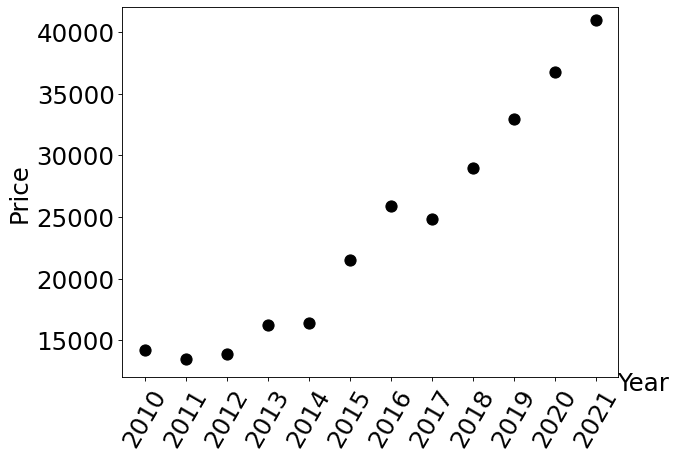

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
ax.plot(price_df.index, price_data['Price'], 'ko', markersize=10)
ax.set_xlabel("Year")
ax.set_xticks(price_df.index)
ax.set_xticklabels(price_data['Year'], rotation=60)
ax.xaxis.set_label_coords(1.05, 0.015)
ax.set_ylabel("Price")
ax.set_ylim(12000, 42000)

从图形上看，房价大致与年份成线性关系，特别是2017年-2021年间。

因此，选用线性回归模型进行预测大体上是合理的。

### 最小二乘解

In [5]:
import sys
sys.path.insert(1, '../')
from utils.utils import *
from LinearRegression_2 import *


psource(LinearRegressionLS)

#### 实现要点

```py
def linout(self, xlist):
    """ linear output for given data """
    return 自变量 * 权重 + 偏置
```

```py
def homogeneous(self, xlist):
    """ build homogeneous coordinates """
    xlist 转换成列向量
    return xlist + 全是1的列向量
```

```py
def loss_sq(self, X, Y):
    """ loss function: (half) sum of square errors """
    return （(预测值 - 真实值）的平方）求和后除以2
```

```py
def solve(self, lr, nepoch):
    """ form normal equation """
    XtX = X转置 * X
    XtY = X转置 * Y
    权重W = XtX求逆 * XtY
```

### 梯度下降法

In [6]:
psource(LinearRegressionGD1)

#### 实现要点

```py
def gd(self, lr):
    """ gradient descent update """
    def gradient(Y_hat, Y, X):
        return （(预测值 - 真实值Y） * 自变量X）求和

    预测值 = linout(X)
    梯度值 = gradient(预测值, Y, X)
    梯度下降更新：权重W -= 学习率lr * 梯度值
```

### 学习率测试

学习率的取值可以决定优化过程是否收敛。

- 尝试将学习率改成$0.03$并重新运行，观察误差的变化并解释原因

## 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [2]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.9279, -0.3628]) 
label: tensor([1.5922])


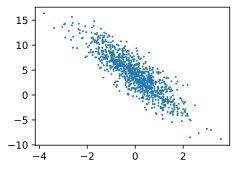

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 这些样本是随机读取的，没有特定的顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4983, -0.6839],
        [ 0.9086,  0.1984],
        [-0.9412,  1.7741],
        [ 0.5633,  0.5367],
        [-0.5475,  1.1045],
        [-0.4858,  0.1637],
        [-0.6546,  0.7451],
        [ 0.0917, -0.5540],
        [ 1.0365,  0.3422],
        [-1.3411,  1.1863]]) 
 tensor([[ 7.5235],
        [ 5.3381],
        [-3.7026],
        [ 3.5037],
        [-0.6498],
        [ 2.6669],
        [ 0.3536],
        [ 6.2596],
        [ 5.1234],
        [-2.5214]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型，将模型的输入和参数同模型的输出关联起来

In [8]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [9]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [10]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。
        l.sum().backward()  # l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035369
epoch 2, loss 0.000128
epoch 3, loss 0.000051


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0011, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

通过使用深度学习框架来简洁地实现线性回归模型

首先生成数据集

In [13]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

调用框架中现有的API来读取数据

In [14]:
def load_array(data_arrays, batch_size, is_train=True):  
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.7491,  1.8152],
         [ 2.4920,  0.1592],
         [ 1.9233,  0.3220],
         [ 0.8503,  1.4565],
         [ 0.4859,  0.6209],
         [-0.9299, -1.5807],
         [ 1.8116,  1.2680],
         [ 0.7691,  0.2507],
         [ 0.8320, -0.9070],
         [ 0.5925,  0.2233]]),
 tensor([[-3.4789],
         [ 8.6513],
         [ 6.9465],
         [ 0.9517],
         [ 3.0479],
         [ 7.7058],
         [ 3.5047],
         [ 4.8805],
         [ 8.9502],
         [ 4.6297]])]

使用框架的预定义好的层

In [15]:
from torch import nn  # nn是神经网络的缩写

net = nn.Sequential(nn.Linear(2, 1))

初始化模型参数

In [16]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

计算均方误差使用的是`MSELoss`类，也称为平方$L_2$范数

In [17]:
loss = nn.MSELoss()

实例化一个`SGD`实例

In [18]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

训练过程代码与我们从零开始实现时所做的非常相似

In [19]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000356
epoch 2, loss 0.000104
epoch 3, loss 0.000105


比较生成数据集的真实参数和通过有限数据训练获得的模型参数

In [20]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0005,  0.0009])
b的估计误差： tensor([-0.0008])
